In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, Adadelta, SGD
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT = "/home/dotamthuc/Works/Projects/"
LOG_DIR = os.path.join(ROOT, "unrollGTV/model_multiscale_mixture_GLR/result/model_test09/logs/")
sys.path.append(os.path.join(ROOT, 'unrollGTV/model_multiscale_mixture_GLR/lib'))
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)
#########################################################################################################

from dataloader import ImageSuperResolution
import model_MMGLR as model_structure


In [2]:

CHECKPOINT_DIR = os.path.join(ROOT, "unrollGTV/model_multiscale_mixture_GLR/result/model_test09/checkpoints/")
VERBOSE_RATE = 1000

(H_train, W_train) = (128, 128)
(H_val, W_val) = (320, 320)
(H_test, W_test) = (496, 496)

train_dataset = ImageSuperResolution(
    csv_path="/home/dotamthuc/Works/Projects/unrollGTV/data/datasets/DIV2K/DIV2K_train_HR_info.csv",
    dist_mode="addictive_noise_scale",
    lambda_noise=15.0,
    patch_size=H_train,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder="/home/dotamthuc/Works/Projects/unrollGTV/data",
    logger=LOGGER,
    device=DEVICE,
)

validation_dataset = ImageSuperResolution(
    csv_path="/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/CBSD68_testing_data_info.csv",
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_val,
    patch_overlap_size=0,
    max_num_patchs=10000,
    root_folder="/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/",
    logger=LOGGER,
    device=DEVICE,
)

test_dataset = ImageSuperResolution(
    csv_path="/home/dotamthuc/Works/Projects/unrollGTV/data/datasets/McM_test_info.csv",
    dist_mode="addictive_noise",
    lambda_noise=15.0,
    patch_size=H_test,
    patch_overlap_size=0,
    max_num_patchs=10000,
    root_folder="/home/dotamthuc/Works/Projects/unrollGTV/data",
    logger=LOGGER,
    device=DEVICE,
)


data_train_batched = torch.utils.data.DataLoader(
    train_dataset, batch_size=4
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=1
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1
)

In [3]:

NUM_EPOCHS = 45
# CONNECTION_FLAGS = np.array([
#     1,1,1,1,1,
#     1,1,1,1,1,
#     1,1,0,1,1,
#     1,1,1,1,1,
#     1,1,1,1,1,
# ]).reshape((5,5))


CONNECTION_FLAGS = np.array([
    1,1,1,
    1,0,1,
    1,1,1,
]).reshape((3,3))

modelConf = {"ModelLightWeightTransformerGLR": {
    "img_height":H_train,
    "img_width":W_train,
    "n_blocks":5,
    "n_graphs":4,
    "n_levels":4,
    "device": DEVICE,
    "global_mmglr_confs" : {
        "n_graphs":4,
        "n_levels":4,
        "n_cgd_iters":5,
        "alpha_init":0.5,
        "muy_init": torch.tensor([[0.3], [0.15], [0.075], [0.0375]]).to(DEVICE),
        "beta_init":0.1,
        "device":DEVICE,
        "GLR_modules_conf": [
            {"GLRConf":{
                "input_width": H_train,
                "input_height": W_train,
                "n_channels": 9,
                "n_node_fts": 8,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
            {"GLRConf":{
                "input_width": H_train//2,
                "input_height": W_train//2,
                "n_channels": 9,
                "n_node_fts": 8,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
            {"GLRConf":{
                "input_width": H_train//4,
                "input_height": W_train//4,
                "n_channels": 9,
                "n_node_fts": 16,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
            {"GLRConf":{
                "input_width": H_train//8,
                "input_height": W_train//8,
                "n_channels": 9,
                "n_node_fts": 32,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
        ],
        "Extractor_modules_conf":[
            {"ExtractorConf":{
                "n_features_in": 32,
                "n_features_out": 32,
                "n_channels_in": 9,
                "n_channels_out": 9,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 32,
                "n_features_out": 64,
                "n_channels_in": 9,
                "n_channels_out": 9,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 64,
                "n_features_out": 128,
                "n_channels_in": 9,
                "n_channels_out": 9,
                "device": DEVICE
            }},
        ]}
    }
}

model = model_structure.ModelLightWeightTransformerGLR(**modelConf["ModelLightWeightTransformerGLR"])
# model.compile()
s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    print(p.dtype, np.array(p.shape), s)


criterian = nn.MSELoss()
optimizer = Adam(
    model.parameters(),
    lr=0.001,
    eps=1e-08
)

torch.float32 [5] 5
torch.float32 [4 4] 21
torch.float32 [5 4] 41
torch.float32 [5 4] 61
torch.float32 [4] 65
torch.float32 [9 3 3 3] 308
torch.float32 [9 3 3 3] 551
torch.float32 [32  9  3  3] 3143
torch.float32 [4 8 8] 3399
torch.float32 [4 2] 3407
torch.float32 [27  1  3  3] 3650
torch.float32 [4 8 8] 3906
torch.float32 [4 2] 3914
torch.float32 [27  1  3  3] 4157
torch.float32 [ 4 16 16] 5181
torch.float32 [4 2] 5189
torch.float32 [27  1  3  3] 5432
torch.float32 [ 4 32 32] 9528
torch.float32 [4 2] 9536
torch.float32 [27  1  3  3] 9779
torch.float32 [9 1 3 3] 9860
torch.float32 [ 8 32  3  3] 12164
torch.float32 [8] 12172
torch.float32 [8 8 3 3] 12748
torch.float32 [9 1 3 3] 12829
torch.float32 [16 32  3  3] 17437
torch.float32 [16] 17453
torch.float32 [16 16  3  3] 19757
torch.float32 [9 1 3 3] 19838
torch.float32 [32 64  3  3] 38270
torch.float32 [32] 38302
torch.float32 [32 32  3  3] 47518
torch.float32 [4 4] 47534
torch.float32 [5 4] 47554
torch.float32 [5 4] 47574
torch.float32 

In [4]:

# training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0024k.pt')
# training_state = torch.load(training_state_path)
# model.load_state_dict(training_state["model"])
# optimizer.load_state_dict(training_state["optimizer"])

In [21]:
model.graph_frame_recalibrate(H_val, W_val)

# ### VALIDAING
model.eval()
list_val_mse = []
val_i = 0
for val_patchs_noisy, val_patchs_true in data_valid_batched:
    s = time.time()
    with torch.no_grad():
        reconstruct_patchs = model(val_patchs_noisy)
        img_true = np.clip(val_patchs_true.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        val_mse_value = np.square(img_true- img_recon).mean()
        list_val_mse.append(val_mse_value)
        print(f"val_i={val_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/val_mse_value)}")
    val_i+=1

psnr_validation = 10 * np.log10(1/np.array(list_val_mse))
print(f"psnr_validation={np.mean(psnr_validation)}")

val_i=0 time=0.3106658458709717 test_i_psnr_value=32.07798788148581
val_i=1 time=0.3136632442474365 test_i_psnr_value=30.045214292837773
val_i=2 time=0.34347987174987793 test_i_psnr_value=29.49032344453165
val_i=3 time=0.3404998779296875 test_i_psnr_value=30.187569030621454
val_i=4 time=0.34534239768981934 test_i_psnr_value=28.72512744973257
val_i=5 time=0.34748077392578125 test_i_psnr_value=31.102644841092804
val_i=6 time=0.3477210998535156 test_i_psnr_value=28.48939760771667
val_i=7 time=0.3449366092681885 test_i_psnr_value=30.34100031778118
val_i=8 time=0.3416132926940918 test_i_psnr_value=29.946392089900705
val_i=9 time=0.3437983989715576 test_i_psnr_value=29.893971730331028
val_i=10 time=0.34862709045410156 test_i_psnr_value=33.12951220462976
val_i=11 time=0.3477799892425537 test_i_psnr_value=28.556302080352136
val_i=12 time=0.3505058288574219 test_i_psnr_value=28.716487376536893
val_i=13 time=0.34967565536499023 test_i_psnr_value=26.72308972989073
val_i=14 time=0.3455514907836914

In [5]:

# training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0016k.pt')
# training_state = torch.load(training_state_path)
# model.load_state_dict(training_state["model"])


In [6]:
print(f"model.cumulative_result_weight={model.cumulative_result_weight} type={model.cumulative_result_weight.dtype}")
for block_t in range(5):
    print(f"block={block_t}.muys={model.light_weight_transformer_blocks[block_t].muys} type={model.light_weight_transformer_blocks[block_t].muys.dtype}")
    print(f"block={block_t}.combination_weight={model.light_weight_transformer_blocks[block_t].combination_weight} type={model.light_weight_transformer_blocks[block_t].combination_weight.dtype}")
    # print(f"block={block_t}.alphaCGD={model.light_weight_transformer_blocks[block_t].alphaCGD}")
    # print(f"block={block_t}.betaCGD={model.light_weight_transformer_blocks[block_t].betaCGD}")

model.cumulative_result_weight=Parameter containing:
tensor([0.9544, 0.6587, 0.5902, 0.5015, 0.6867], device='cuda:0',
       requires_grad=True) type=torch.float64
block=0.muys=Parameter containing:
tensor([[ 0.2675,  0.1569,  0.5106,  0.4280,  0.3021,  0.7074,  0.3326,  0.4279,
          0.4386],
        [ 0.4824,  0.5667,  0.1121,  0.2400, -0.1997,  0.4065,  0.3120,  0.3498,
          0.1372],
        [-0.2336, -0.4116,  0.1734,  0.0390,  0.1250,  0.1740,  0.1035,  0.0457,
          0.1142],
        [ 0.4456, -0.2030, -0.0706, -0.0398, -0.0252, -0.0216, -0.0577, -0.1526,
          0.0778]], device='cuda:0', requires_grad=True) type=torch.float64
block=0.combination_weight=Parameter containing:
tensor([0.1058, 0.0996, 0.1082, 0.1006, 0.0943, 0.1171, 0.0938, 0.1021, 0.0992],
       device='cuda:0', requires_grad=True) type=torch.float64
block=1.muys=Parameter containing:
tensor([[ 0.3452,  0.6158,  0.3008,  0.2724,  0.3009,  0.6368,  0.3755,  0.2281,
          0.3781],
        [ 0.202

In [11]:
for block_t in range(5):
    print(f"block={block_t}.highest_stats={model.light_weight_transformer_blocks[block_t].highest_stats}")

block=0.highest_stats=Parameter containing:
tensor([[[[-0.0994,  0.3466, -0.2330],
          [-0.0497,  1.0484, -0.2868],
          [-0.0634, -0.5556, -0.2024]]],


        [[[ 0.0171, -0.1396,  0.0578],
          [ 0.0140, -0.6907,  0.1371],
          [-0.0094,  0.5045,  0.0893]]],


        [[[ 0.0146, -0.0604,  0.2001],
          [ 0.1182,  0.7264, -0.1084],
          [ 0.0461, -0.7550, -0.0402]]],


        [[[-0.1571,  0.4980, -0.2963],
          [ 0.0270,  1.0202, -0.0510],
          [ 0.0511, -0.7241, -0.2944]]],


        [[[-0.1502,  0.1480, -0.1178],
          [ 0.1139, -0.7037,  0.2108],
          [-0.0932,  0.6542, -0.1039]]],


        [[[-0.0689, -0.0280,  0.1691],
          [ 0.0694,  0.8034, -0.2715],
          [ 0.0260, -0.6774,  0.0290]]],


        [[[-0.0439,  0.2496, -0.1455],
          [ 0.0247,  0.9421, -0.1694],
          [-0.0836, -0.5988, -0.1954]]],


        [[[-0.0285, -0.0360, -0.0311],
          [-0.0169, -0.5496,  0.0577],
          [-0.0338,  0.5476,  0

In [9]:
model.light_weight_transformer_blocks[0].patchs_embeding.weight


Parameter containing:
tensor([[[[ 0.0009, -0.0044,  0.1079],
          [-0.0932,  0.2928,  0.0030],
          [ 0.0371, -0.0865, -0.0670]],

         [[ 0.1816, -0.2593, -0.0850],
          [ 0.2234,  0.3481, -0.3144],
          [ 0.0619, -0.1370, -0.0473]],

         [[-0.2116,  0.2064, -0.0899],
          [-0.0600,  0.0710,  0.0456],
          [ 0.1967, -0.2453,  0.2258]]],


        [[[ 0.2079, -0.4201, -0.0321],
          [ 0.0752, -0.1100, -0.2075],
          [-0.1658,  0.5103,  0.1014]],

         [[-0.4613,  0.0846,  0.0458],
          [ 0.0104, -0.2793,  0.4679],
          [-0.1043,  0.2774,  0.0474]],

         [[ 0.3581, -0.4195,  0.0136],
          [-0.0432, -0.2177,  0.1321],
          [ 0.1173, -0.0373,  0.0214]]],


        [[[-0.1137, -0.0299, -0.1329],
          [ 0.0892, -0.0251,  0.0780],
          [ 0.0083,  0.0436,  0.1480]],

         [[-0.1577,  0.0972,  0.0187],
          [ 0.0513, -0.0523,  0.2234],
          [ 0.0265,  0.0800, -0.0303]],

         [[ 0.1109, -0

In [6]:
for i in range(3):
    print(f"i={i}.down_sampling_kernel=\n{model.light_weight_transformer_blocks[0].list_Extractor[i].down_sampling_kernel.detach().cpu().numpy()}")

i=0.down_sampling_kernel=
[[[[0.11011145 0.1101114  0.11011159]
   [0.11011138 0.11011131 0.11011137]
   [0.11011157 0.11011138 0.11011142]]]


 [[[0.11011144 0.11011139 0.11011158]
   [0.11011136 0.1101113  0.11011136]
   [0.11011155 0.11011136 0.1101114 ]]]


 [[[0.11011157 0.11011148 0.11011177]
   [0.11011146 0.11011136 0.11011145]
   [0.11011173 0.11011145 0.11011151]]]]
i=1.down_sampling_kernel=
[[[[0.11011732 0.11011541 0.11011744]
   [0.11011475 0.11011373 0.11011452]
   [0.11011688 0.1101151  0.11011583]]]


 [[[0.11011869 0.11011584 0.11011778]
   [0.1101151  0.11011388 0.11011489]
   [0.11011704 0.1101154  0.11011672]]]


 [[[0.11012366 0.11011909 0.11012094]
   [0.11011682 0.11011532 0.11011645]
   [0.11011925 0.11011796 0.11011954]]]]
i=2.down_sampling_kernel=
[[[[0.11022414 0.11021139 0.11022248]
   [0.11019278 0.11017008 0.1101888 ]
   [0.1102629  0.11020532 0.11023419]]]


 [[[0.11025235 0.11025357 0.11025347]
   [0.1102048  0.11018617 0.11020498]
   [0.11023048 0.11021

In [7]:
for i in range(3):
    print(f"i={i}.down_sampling_kernel=\n{model.light_weight_transformer_blocks[0].list_mixtureGLR[i].stats_kernel.detach().cpu().numpy()}")

i=0.down_sampling_kernel=
[[[[-9.9988410e-04 -9.9987746e-04  9.9787535e-04]
   [-9.9990366e-04  9.9900007e-01 -9.9990540e-04]
   [ 9.9822797e-04 -9.9987688e-04 -9.9988561e-04]]]


 [[[ 9.9974975e-04 -9.9727721e-04 -9.9975581e-04]
   [ 9.9980738e-04 -4.9900016e-01  4.9900019e-01]
   [ 9.9672715e-04  9.9976838e-04  9.9825952e-04]]]


 [[[ 9.9977653e-04  9.9982705e-04  9.9912367e-04]
   [ 9.9879876e-04 -4.9900013e-01  9.9981937e-04]
   [-9.9980482e-04  4.9900016e-01 -9.9781470e-04]]]


 [[[-9.9989295e-04 -9.9989062e-04  9.9896512e-04]
   [-9.9990889e-04  9.9900001e-01 -9.9991064e-04]
   [ 9.9908770e-04 -9.9988945e-04 -9.9989399e-04]]]


 [[[ 9.9979236e-04 -9.9586800e-04 -9.9979283e-04]
   [ 9.9983497e-04 -4.9900013e-01  4.9900016e-01]
   [ 9.9629234e-04  9.9980144e-04  9.9773018e-04]]]


 [[[ 9.9979714e-04  9.9984941e-04  9.9911378e-04]
   [ 9.9872763e-04 -4.9900013e-01  9.9983625e-04]
   [-9.9982531e-04  4.9900013e-01 -9.9777209e-04]]]


 [[[-9.9985977e-04 -9.9985511e-04  9.9937583e-04]


In [6]:
w = torch.cat([
    torch.ones((6, 1, 3, 3), dtype=torch.float32),
])
w.shape

torch.Size([6, 1, 3, 3])

In [7]:
x = torch.ones((3, 8, 8), dtype=torch.float32)
x

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
       

In [8]:
wx = torch.nn.functional.conv2d(
    x,
    weight=w,
    stride=2,
    padding=1,
    dilation=1,
    bias=None,
    groups=3
)
wx, wx.shape

(tensor([[[4., 6., 6., 6.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.]],
 
         [[4., 6., 6., 6.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.]],
 
         [[4., 6., 6., 6.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.]],
 
         [[4., 6., 6., 6.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.]],
 
         [[4., 6., 6., 6.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.]],
 
         [[4., 6., 6., 6.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.],
          [6., 9., 9., 9.]]]),
 torch.Size([6, 4, 4]))

In [9]:
wx[:, :-1, :-1]=0.0
wx[:, :-1, :]=0.0
wx[:, :, :-1]=0.0
wx

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 9.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 9.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 9.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 9.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 9.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 9.]]])

In [10]:
wx.shape

torch.Size([6, 4, 4])

In [11]:
wwx = torch.nn.functional.conv_transpose2d(
    wx,
    weight=w,
    stride=2,
    padding=0,
    dilation=1,
    bias=None,
    groups=3
)
wwx, wwx.shape

(tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0., 18., 18., 18.],
          [ 0.,  0.,  0.,  0.,  0.,  0., 18., 18., 18.],
          [ 0.,  0.,  0.,  0.,  0.,  0., 18., 18., 18.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0., 18., 18., 18.],
          [ 0.,  0.,  0.,  0.,  0.,  0., 18., 18., 18.],
          [ 0.,  0.,  0.,  0

In [96]:
x = torch.ones((3, 8, 8), dtype=torch.float32)
x

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
       

In [97]:
wx = torch.nn.functional.conv2d(
    x,
    weight=w,
    stride=1,
    padding=1,
    dilation=1,
    bias=None
)
wx

tensor([[[0.4444, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4444],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.4444, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4444]],

        [[0.4444, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4444],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.000

In [98]:
dwx = torch.nn.functional.pixel_unshuffle(wx, 2)
dwx

tensor([[[0.4444, 0.6667, 0.6667, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000],
         [0.6667, 1.0000, 1.0000, 1.0000],
         [0.6667, 1.0000, 1.0000, 1.0000]],

        [[0.6667, 0.6667, 0.6667, 0.4444],
         [1.0000, 1.0000, 1.0000, 0.6667],
         [1.0000, 1.0000, 1.0000, 0.6667],
         [1.0000, 1.0000, 1.0000, 0.6667]],

        [[0.6667, 1.0000, 1.0000, 1.0000],
         [0.6667, 1.0000, 1.0000, 1.0000],
         [0.6667, 1.0000, 1.0000, 1.0000],
         [0.4444, 0.6667, 0.6667, 0.6667]],

        [[1.0000, 1.0000, 1.0000, 0.6667],
         [1.0000, 1.0000, 1.0000, 0.6667],
         [1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 0.6667, 0.6667, 0.4444]],

        [[0.4444, 0.6667, 0.6667, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000],
         [0.6667, 1.0000, 1.0000, 1.0000],
         [0.6667, 1.0000, 1.0000, 1.0000]],

        [[0.6667, 0.6667, 0.6667, 0.4444],
         [1.0000, 1.0000, 1.0000, 0.6667],
         [1.0000, 1.0000, 1.0000, 0.6667],
 

In [99]:
ddwx = torch.nn.functional.pixel_shuffle(dwx, 2)
ddwx

tensor([[[0.4444, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4444],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.4444, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4444]],

        [[0.4444, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4444],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
         [0.6667, 1.000

In [100]:
ddwx[:, 1:, 1:]=0.0
ddwx[:, 1:, :]=0.0
ddwx[:, :, 1:]=0.0
ddwx

tensor([[[0.4444, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.4444, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.000

In [102]:
wddwx = torch.nn.functional.conv_transpose2d(
    ddwx,
    weight=torch.cat([
        torch.ones((2, 3, 3, 3), dtype=torch.float32),
    ]),
    stride=1,
    padding=1,
    dilation=1,
    bias=None
)
wddwx

tensor([[[0.8889, 0.8889, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.8889, 0.8889, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.8889, 0.8889, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.8889, 0.8889, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.000

In [32]:
nn.Sequential(
    nn.Conv2d(
        in_channels=3, 
        out_channels=1, 
        kernel_size=3,
        stride=1,
        padding=1,
        dilation=1,
        padding_mode="zeros",
        bias=False
    ),
)(x)

tensor([[[-0.5403, -0.9221, -0.9221, -0.9221, -0.9221, -0.9221, -0.9221,
          -0.4413],
         [-0.3118, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796,
          -0.8431],
         [-0.3118, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796,
          -0.8431],
         [-0.3118, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796,
          -0.8431],
         [-0.3118, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796,
          -0.8431],
         [-0.3118, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796,
          -0.8431],
         [-0.3118, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796, -0.9796,
          -0.8431],
         [-0.1668, -0.6933, -0.6933, -0.6933, -0.6933, -0.6933, -0.6933,
          -0.7965]]], grad_fn=<SqueezeBackward1>)

In [23]:
a = [
    33.0433,
    32.4546,
    33.6149,
    32.1404,
    32.2527,
    31.3826,
    32.0064,
    34.2567,
    29.3739,
    35.9826,
    31.0941,
    31.2291,
    34.5279,
    34.6471,
    33.8532,
    34.7598,
    33.3181,
    34.0972,
]
np.mean(a)

np.float64(33.00192222222223)

In [22]:
# LOGGER.info(f"Start VALIDATION EPOCH {epoch} - iter={i}")
model.graph_frame_recalibrate(H_test, W_test)

# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        reconstruct_patchs = model(test_patchs_noisy)
        test_mse = criterian(reconstruct_patchs, test_patchs_true)
        test_mse_value = test_mse.cpu().numpy()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")
    test_i+=1

psnr_validation = 10 * np.log10(1/np.mean(list_test_mse))
psnr_validation

test_i=0 time=0.9973177909851074 test_i_psnr_value=32.44253158569336
test_i=1 time=1.0333442687988281 test_i_psnr_value=30.991945266723633
test_i=2 time=1.0136487483978271 test_i_psnr_value=33.27387237548828
test_i=3 time=1.023460865020752 test_i_psnr_value=31.247344970703125
test_i=4 time=0.9852161407470703 test_i_psnr_value=31.384660720825195
test_i=5 time=0.9592041969299316 test_i_psnr_value=29.979808807373047
test_i=6 time=0.9512364864349365 test_i_psnr_value=31.17261505126953
test_i=7 time=0.9418430328369141 test_i_psnr_value=33.58390426635742
test_i=8 time=1.0558347702026367 test_i_psnr_value=27.89006996154785
test_i=9 time=0.953514575958252 test_i_psnr_value=36.66819763183594
test_i=10 time=0.9448451995849609 test_i_psnr_value=29.810741424560547
test_i=11 time=0.915747880935669 test_i_psnr_value=30.79105567932129
test_i=12 time=0.9044492244720459 test_i_psnr_value=34.639564514160156
test_i=13 time=0.9104921817779541 test_i_psnr_value=34.493446350097656
test_i=14 time=0.900758743

np.float32(31.832874)

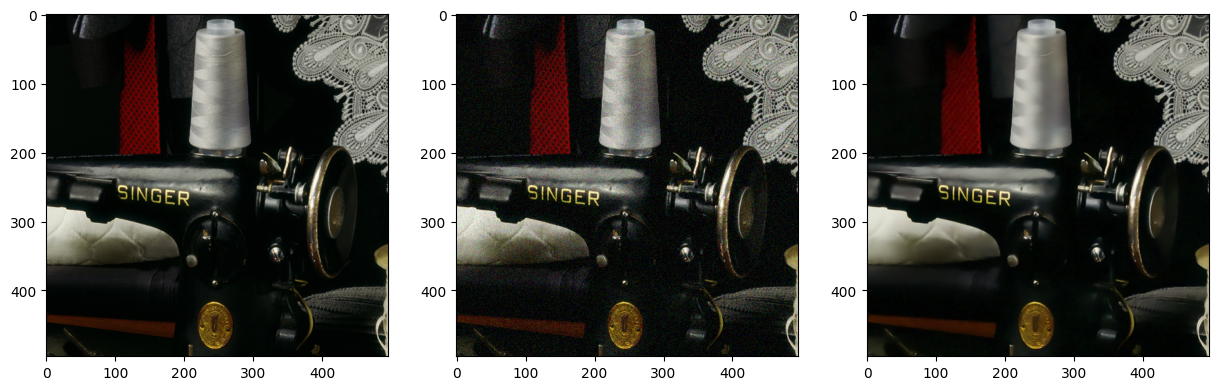

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

hh, ww = (496, 496)
axs[0].imshow((test_patchs_true[0][:hh, :ww].cpu().numpy()))
axs[1].imshow((test_patchs_noisy[0][:hh, :ww].cpu().numpy()))
axs[2].imshow((reconstruct_patchs[0][:hh, :ww].cpu().numpy()))
plt.show()

In [4]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, ) as prof:
#     with record_function("model_inference"):
#         # with torch.no_grad():
#         #     reconstruct_patchs = model(patchs_noisy)
#         optimizer.zero_grad()
#         reconstruct_patchs = model(patchs_noisy)
#         loss_mse = criterian(reconstruct_patchs, patchs_true)
#         loss_mse.backward()
#         optimizer.step()

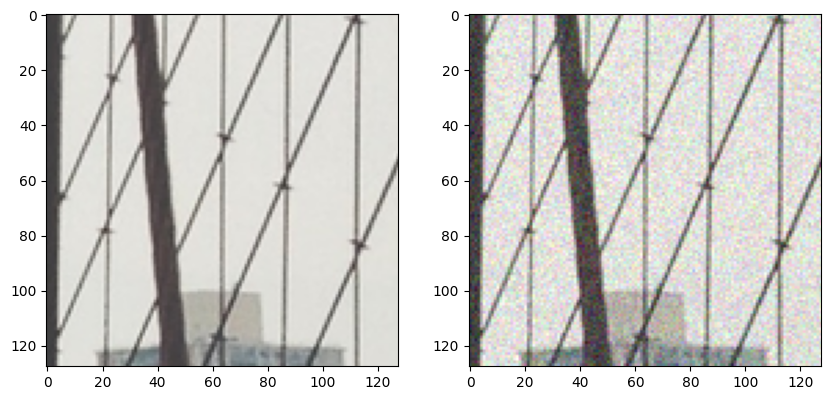

In [11]:
# print(prof.key_averages(group_by_input_shape=False).table(sort_by="cuda_time_total", row_limit=-1))

for patchs_noisy, patchs_true in data_train_batched:
    break

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

hh, ww = (416, 416)
axs[0].imshow((patchs_true[0][:hh, :ww].cpu().numpy()))
axs[1].imshow((patchs_noisy[0][:hh, :ww].cpu().numpy()))
plt.show()

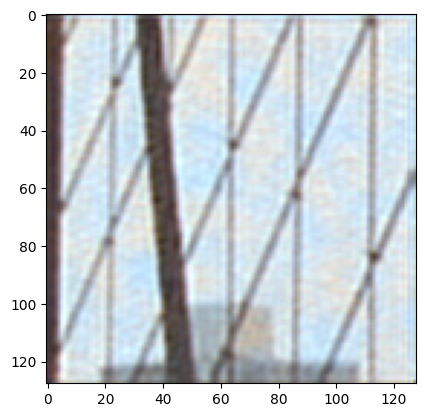

In [12]:
with torch.no_grad():
    reconstruct_patchs = model(patchs_noisy)
plt.imshow((reconstruct_patchs[0][:hh, :ww].cpu().numpy()))

In [5]:
model_fast = nn.Sequential(
    nn.Conv2d(
        in_channels=3, 
        out_channels=9, 
        kernel_size=3,
        stride=1,
        padding=1,
        dilation=1,
        padding_mode="reflect",
        bias=False
    ),
    nn.ReLU(),
    nn.ConvTranspose2d(
        in_channels=9,  
        out_channels=3,
        kernel_size=3,
        stride=1,
        padding=1,
        dilation=1,
        padding_mode="zeros",
        bias=False
    ),
    nn.ReLU()
).to(DEVICE)

# model_fast = nn.Sequential(
#     nn.Conv2d(3, 9, kernel_size=1, bias=False),
#     nn.Conv2d(9, 9, kernel_size=3, stride=1, padding=1, groups=9, bias=False),
#     nn.Conv2d(9, 9, kernel_size=3, stride=1, padding=1, groups=9, bias=False),
#     nn.Conv2d(9, 3, kernel_size=1, bias=False)
# ).to(DEVICE)

criterian = nn.MSELoss()
optimizer = Adam(
    model_fast.parameters(),
    lr=0.001,
    eps=1e-08
)

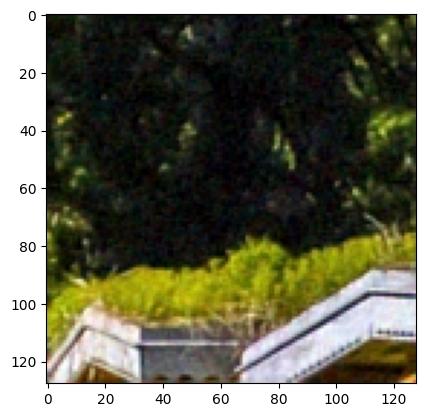

In [8]:

with torch.no_grad():
    b, h, w, c = patchs_noisy.shape
    reconstruct_patchs = model_fast(patchs_noisy.permute((0, 3, 1, 2))).permute((0, 2, 3, 1))
plt.imshow((reconstruct_patchs[0][:hh, :ww].cpu().numpy()))

In [10]:

model.graph_frame_recalibrate(H_train, W_train)
i = 0
s = time.time()
for patchs_noisy, patchs_true in data_train_batched:
    if i > 3000:
        break
    s = time.time()
    optimizer.zero_grad()
    # reconstruct_patchs = model_fast(patchs_noisy.permute((0, 3, 1, 2))).permute((0, 2, 3, 1))

    reconstruct_patchs = model(patchs_noisy)
    loss_mse = criterian(reconstruct_patchs, patchs_true)
    loss_mse.backward()
    optimizer.step()
    psnr = 10 * np.log10(1/np.mean(loss_mse.detach().cpu().numpy()))
    print(f"i = {i} loss_mse={loss_mse} psnr={psnr} time={time.time()-s}")
    i+=1

i = 0 loss_mse=0.3593171238899231 psnr=4.445220947265625 time=1.57265305519104
i = 1 loss_mse=0.463833749294281 psnr=3.336376667022705 time=1.452772855758667
i = 2 loss_mse=0.4264197051525116 psnr=3.701627254486084 time=1.5329437255859375
i = 3 loss_mse=0.14244911074638367 psnr=8.46340274810791 time=1.4669201374053955
i = 4 loss_mse=0.18041718006134033 psnr=7.437220573425293 time=1.5297574996948242
i = 5 loss_mse=0.18159529566764832 psnr=7.408953666687012 time=1.5268962383270264
i = 6 loss_mse=0.4185953140258789 psnr=3.7820565700531006 time=1.4626312255859375
i = 7 loss_mse=0.22031906247138977 psnr=6.569478988647461 time=1.4052128791809082
i = 8 loss_mse=0.21337270736694336 psnr=6.708611488342285 time=1.376664400100708
i = 9 loss_mse=0.36652469635009766 psnr=4.3589677810668945 time=1.3627269268035889
i = 10 loss_mse=0.2373804897069931 psnr=6.245550155639648 time=1.4068973064422607
i = 11 loss_mse=0.1665310263633728 psnr=7.785048484802246 time=1.393937110900879
i = 12 loss_mse=0.2733699

KeyboardInterrupt: 

In [7]:

list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        # reconstruct_patchs = model_fast(test_patchs_noisy.permute((0, 3, 1, 2))).permute((0, 2, 3, 1))
        reconstruct_patchs = model(test_patchs_noisy)

        img01 = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img02 = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img01- img02).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1**2/test_mse_value)}")
    test_i+=1


psnr_validation = 10 * np.log10(1**2/np.mean(list_test_mse))
psnr_validation

AssertionError: h_size != self.input_height

In [35]:
# LOGGER.info(f"Start VALIDATION EPOCH {epoch} - iter={i}")
model.graph_frame_recalibrate(H_test, W_test)

# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        reconstruct_patchs = model(test_patchs_noisy)

        img01 = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img02 = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img01- img02).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1**2/test_mse_value)}")
    test_i+=1


psnr_validation = 10 * np.log10(1**2/np.mean(list_test_mse))
psnr_validation

test_i=0 time=0.9775598049163818 test_i_psnr_value=32.43381550376994
test_i=1 time=1.002866506576538 test_i_psnr_value=31.023072783508553
test_i=2 time=1.0281424522399902 test_i_psnr_value=33.24051147352728
test_i=3 time=1.025867223739624 test_i_psnr_value=31.262665700441005
test_i=4 time=1.0401191711425781 test_i_psnr_value=31.39368276942819
test_i=5 time=1.0227859020233154 test_i_psnr_value=29.990281110406816
test_i=6 time=1.0394752025604248 test_i_psnr_value=31.138977710499127
test_i=7 time=1.056034803390503 test_i_psnr_value=33.57961577736884
test_i=8 time=1.0360567569732666 test_i_psnr_value=27.9599885922477
test_i=9 time=1.0326387882232666 test_i_psnr_value=36.677778871015676
test_i=10 time=1.0296902656555176 test_i_psnr_value=29.81547165011554
test_i=11 time=1.0394752025604248 test_i_psnr_value=30.832157035638513
test_i=12 time=1.0369822978973389 test_i_psnr_value=34.63923792077682
test_i=13 time=1.0612268447875977 test_i_psnr_value=34.48039310192172
test_i=14 time=1.04432773590

np.float64(31.844735972597647)

In [36]:

psnr_validation = 10 * np.log10(1**2/np.array(list_test_mse))
psnr_validation, np.mean(psnr_validation)

(array([32.4338155 , 31.02307278, 33.24051147, 31.2626657 , 31.39368277,
        29.99028111, 31.13897771, 33.57961578, 27.95998859, 36.67777887,
        29.81547165, 30.83215704, 34.63923792, 34.4803931 , 33.30398933,
        34.48724292, 31.81087259, 34.13103897]),
 np.float64(32.34448854508084))

In [37]:

psnr_validation = 10 * np.log10(255**2/np.mean(list_test_mse))
psnr_validation

np.float64(79.97553958127676)

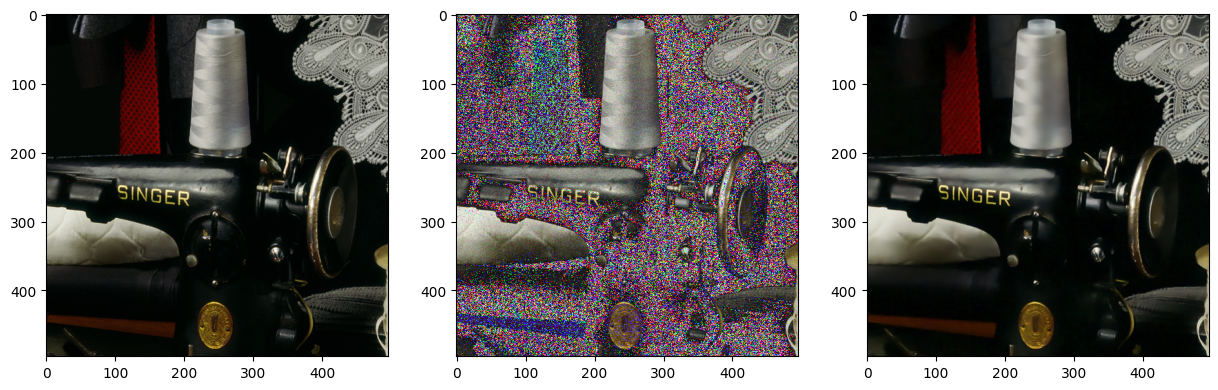

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

hh, ww = (496, 496)
axs[0].imshow((test_patchs_true[0][:hh, :ww].cpu().numpy() * 255).astype(np.uint8))
axs[1].imshow((test_patchs_noisy[0][:hh, :ww].cpu().numpy() * 255).astype(np.uint8))
axs[2].imshow(np.clip(reconstruct_patchs[0][:hh, :ww].cpu().numpy()*255, a_min=0.0, a_max=255.0).astype(np.uint8))
plt.show()

In [9]:
test_dataset.patchs_data.iloc[-1]["path"]

'/home/dotamthuc/Works/Projects/unrollGTV/data/datasets/McM/8.tif'

In [38]:

def load_img(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

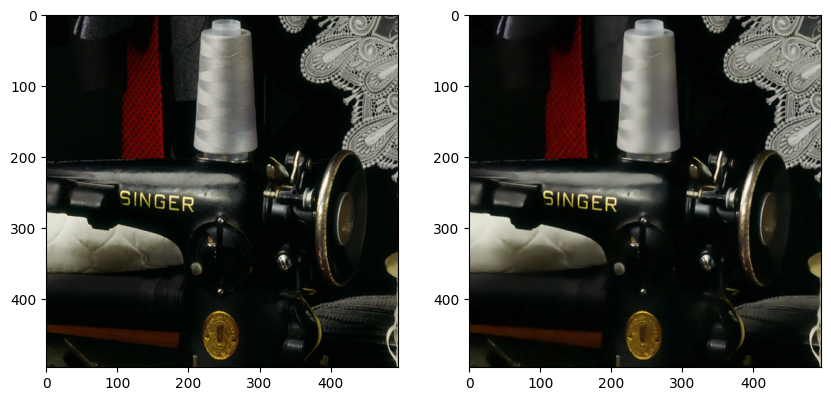

True

In [39]:

from skimage import img_as_ubyte

img01 = np.clip(test_patchs_true[0][:hh, :ww].cpu().numpy(), a_min=0.0, a_max=1.0)
img02 = np.clip(reconstruct_patchs[0][:hh, :ww].cpu().numpy(), a_min=0.0, a_max=1.0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img01)
axs[1].imshow(img02)

plt.show()

cv2.imwrite("img_recon.png", cv2.cvtColor(img_as_ubyte(img02), cv2.COLOR_RGB2BGR))


In [45]:

tar, prd = (
    '/home/dotamthuc/Works/Projects/unrollGTV/data/datasets/McM/8.tif',
    '/home/dotamthuc/Works/Projects/unrollGTV/img_recon.png'
)
tar_img = load_img(tar)
prd_img = load_img(prd)
    
calculate_psnr(tar_img[:496, :496], prd_img)

np.float64(34.11641307215233)

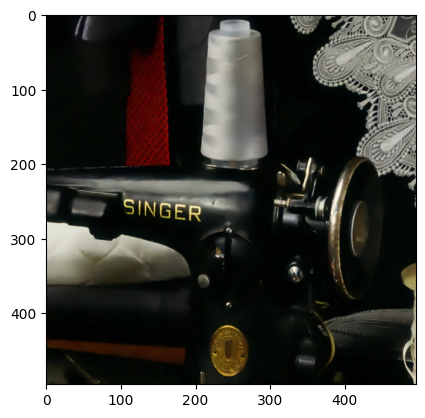

In [41]:
plt.imshow(prd_img)

In [42]:
img01 = np.clip(test_patchs_true[0][:hh, :ww].cpu().numpy()*255, a_min=0.0, a_max=255.0).astype(np.float64)
img02 = np.clip(reconstruct_patchs[0][:hh, :ww].cpu().numpy()*255, a_min=0.0, a_max=255.0).astype(np.float64)

mse = np.square(img01- img02).mean()
10 * np.log10(255**2/mse)

np.float64(34.13103917684218)

In [43]:
img01 = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
img02 = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)

mse = np.square(img01- img02).mean()
10 * np.log10(1.0/mse)

np.float64(34.13103896972122)

In [44]:
img01 = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0)
img02 = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0)

mse = np.square(img01- img02).mean()
10 * np.log10(1.0/mse)

np.float32(34.13104)

In [9]:
ls /home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset

BSD400/     DIV2K/     Flickr2K/     GaussianTest/     WaterlooED/
BSD400.zip  DIV2K.zip  Flickr2K.zip  GaussianTest.zip  WaterlooED.zip


In [28]:
ls /home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/WaterlooED

00001.bmp  00679.bmp  01357.bmp  02035.bmp  02713.bmp  03391.bmp  04069.bmp
00002.bmp  00680.bmp  01358.bmp  02036.bmp  02714.bmp  03392.bmp  04070.bmp
00003.bmp  00681.bmp  01359.bmp  02037.bmp  02715.bmp  03393.bmp  04071.bmp
00004.bmp  00682.bmp  01360.bmp  02038.bmp  02716.bmp  03394.bmp  04072.bmp
00005.bmp  00683.bmp  01361.bmp  02039.bmp  02717.bmp  03395.bmp  04073.bmp
00006.bmp  00684.bmp  01362.bmp  02040.bmp  02718.bmp  03396.bmp  04074.bmp
00007.bmp  00685.bmp  01363.bmp  02041.bmp  02719.bmp  03397.bmp  04075.bmp
00008.bmp  00686.bmp  01364.bmp  02042.bmp  02720.bmp  03398.bmp  04076.bmp
00009.bmp  00687.bmp  01365.bmp  02043.bmp  02721.bmp  03399.bmp  04077.bmp
00010.bmp  00688.bmp  01366.bmp  02044.bmp  02722.bmp  03400.bmp  04078.bmp
00011.bmp  00689.bmp  01367.bmp  02045.bmp  02723.bmp  03401.bmp  04079.bmp
00012.bmp  00690.bmp  01368.bmp  02046.bmp  02724.bmp  03402.bmp  04080.bmp
00013.bmp  00691.bmp  01369.bmp  02047.bmp  02725.bmp  03403.bmp  04081.bmp
00014.bmp  0

In [12]:
import glob

In [29]:
BSD400 = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/BSD400/*"))
DIV2K = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/DIV2K/*"))
Flickr2K = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/Flickr2K/*"))
WaterlooED = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/WaterlooED/*"))


In [33]:
# index,path,height,width,nchannels
list_img_info = []
for i, path  in enumerate(DIV2K + Flickr2K + WaterlooED + BSD400):
    root = path[:70]
    actual_path = path[70:]

    img = Image.open(path)
    img = np.array(img)

    height, width, nchannels = img.shape
    list_img_info.append({
        "index": i,
        "path": actual_path,
        "height": height,
        "width": width,
        "nchannels": nchannels,
    })
df_img_info = pd.DataFrame(list_img_info)

In [35]:
df_img_info.to_csv("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/DFWB_training_data_info.csv", index=False)

In [2]:
import glob

In [3]:
CBSD68 = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/GaussianTest/test/CBSD68/*"))
McMaster = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/GaussianTest/test/McMaster/*"))
Kodak = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/GaussianTest/test/Kodak/*"))
Urban100 = sorted(glob.glob("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/GaussianTest/test/Urban100/*"))

In [4]:
# index,path,height,width,nchannels
list_img_info = []
for i, path  in enumerate(CBSD68):
    root = path[:70]
    actual_path = path[70:]

    img = Image.open(path)
    img = np.array(img)

    height, width, nchannels = img.shape
    list_img_info.append({
        "index": i,
        "path": actual_path,
        "height": height,
        "width": width,
        "nchannels": nchannels,
    })
df_img_info = pd.DataFrame(list_img_info)
df_img_info.head(), df_img_info.shape

(   index                                       path  height  width  nchannels
 0      0  dataset/GaussianTest/test/CBSD68/0000.png     321    481          3
 1      1  dataset/GaussianTest/test/CBSD68/0001.png     321    481          3
 2      2  dataset/GaussianTest/test/CBSD68/0002.png     321    481          3
 3      3  dataset/GaussianTest/test/CBSD68/0003.png     321    481          3
 4      4  dataset/GaussianTest/test/CBSD68/0004.png     321    481          3,
 (68, 5))

In [5]:
df_img_info.to_csv("/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/dataset/CBSD68_testing_data_info.csv", index=False)

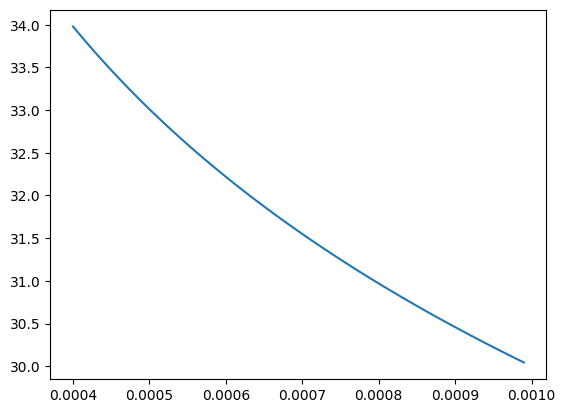

In [10]:
mse = np.arange(0.0004, 0.001, 0.00001)
psnr = 10 * np.log10(1 / mse)
plt.plot(mse, psnr)